# Analysis of NSF awards to WHOI
Created by Ivan Lima on Tue Aug 18 2020 21:05:03 -0400

WHOI is the top organization in terms of number of awards (13.9% of total) and the second largest in terms of total amount awarded (16.3% of total). In this notebook we examine gender differences in the NSF awards that went to WHOI. The metrics we use for gender discrepancies are the annual fraction of female PIs and co-PIs in the awards. We track those metrics across: 

1. All WHOI NSF-OCE awards.
2. Awards from the top 10 largest NSF programs (in number of awards).
3. Identified research topics.
4. Award types

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from tqdm import tnrange, notebook
import warnings
print('Last updated on {}'.format(datetime.datetime.now().ctime()))

Last updated on Tue Nov 10 15:42:32 2020


In [2]:
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 100
pd.options.display.max_columns = 50

Read NSF award data.

In [3]:
data_types = {'Abstract':'string', 'Title':'string', 'Programs':'string', 'PI':'string',
              'Organization':'string', 'State':'string', 'Instrument':'string', 'co-PIs':'string',
              'program':'string', 'PI_first_name':'string', 'co-PI_first_name':'string',
              'PI_gender':'string', 'co-PI_gender':'string'}
awards = pd.read_csv('results/awards_1985-2020_clean_edited_grouped_gender_topic.csv', index_col=0,
                     parse_dates=[4,5], dtype=data_types)

awards['year'] = awards.StartDate.dt.year
# set award types
awards.loc[awards.Title.str.contains('collaborative\s'),'award_type'] = 'Collaborative Research'
awards.loc[awards.Title.str.contains('eager\s'),'award_type'] = 'EAGER'
awards.loc[awards.Title.str.contains('rapid\s'),'award_type'] = 'RAPID'
awards.loc[awards.Title.str.contains('sger\s'),'award_type'] = 'EAGER'
awards.loc[awards.Title.str.contains('reu\s'),'award_type'] = 'REU'
awards.loc[awards.Title.str.contains('rui\s'),'award_type'] = 'RUI'
awards.loc[awards.Title.str.contains('career\s'),'award_type'] = 'CAREER'
awards.loc[awards.Title.str.contains('cmg\s'),'award_type'] = 'CMG'
awards.loc[awards.Title.str.contains('powre\s'),'award_type'] = 'POWRE'
awards['award_type'] = awards.award_type.fillna('standard')

topic_probs = pd.read_csv('results/topic_probs.csv', index_col=0)
topic_words = pd.read_csv('results/topic_words.csv', index_col=0)

npzfile = np.load('results/NMF_TSNE.npz')
feature_names  = npzfile['feature_names']
nmf_components = npzfile['nmf_components']
topic_names    = npzfile['topic_names']
topic_names_r  = npzfile['topic_names_r']
X_tsne         = npzfile['X_tsne']
npzfile.close()

df_ref = pd.read_csv('results/gender_ref.csv',index_col=0)

The figure below shows the number of awards and the amount awarded by NSF Ocean Sciences to WHOI per year, and a box plot of the amount awarded to individual projects in each year between 1987 and 2019.

mean = $65,858,285.10 per year


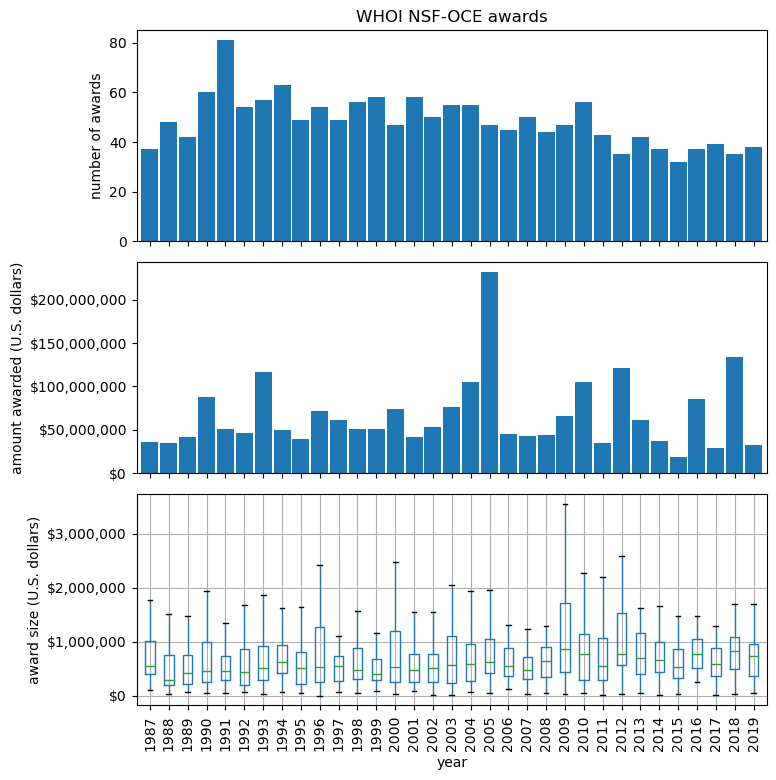

In [4]:
from matplotlib import ticker
def dollar(x, pos):
    return '${:,.0f}'.format(x)
fmt = ticker.FuncFormatter(dollar)

whoi_awards = awards[awards.Organization == 'Woods Hole Oceanographic Institution']
num_awards_per_year_whoi = whoi_awards.groupby([whoi_awards.StartDate.dt.year])['Abstract'].count()
amount_per_year_whoi = whoi_awards.groupby(whoi_awards.StartDate.dt.year)['tot_amount_adjusted'].sum()

fig, axs = plt.subplots(3, 1, figsize=(9,9))
_ = num_awards_per_year_whoi.plot(kind='bar',ax=axs[0], width=0.9, legend=False)
_ = axs[0].set(title='WHOI NSF-OCE awards', ylabel='number of awards', xticklabels='', xlabel='')
_ = amount_per_year_whoi.plot(kind='bar',ax=axs[1], width=0.9)
_ = axs[1].yaxis.set_major_formatter(fmt)
_ = axs[1].set(ylabel='amount awarded (U.S. dollars)', xticklabels='', xlabel='')
_ = whoi_awards.boxplot('tot_amount_adjusted', by='year', showfliers=False,rot=90, ax=axs[2])
_ = axs[2].yaxis.set_major_formatter(fmt)
_ = axs[2].set(title='', ylabel='award size (U.S. dollars)')
_ = axs[2].set_xlim(0.3, 33.7)
fig.subplots_adjust(left=0.2, hspace=0.1)
fig.suptitle('')
print('mean = ${:,.2f} per year'.format(amount_per_year_whoi.mean()))

### Award size by gender

Statistics of the individual awards received by male and female PIs.

In [5]:
whoi_awards_male = whoi_awards[whoi_awards.PI_gender == 'male'][['StartDate','tot_amount_adjusted']]
whoi_awards_female = whoi_awards[whoi_awards.PI_gender == 'female'][['StartDate','tot_amount_adjusted']]

stats = pd.DataFrame({'male PIs': whoi_awards_male.tot_amount_adjusted.describe(),
                      'female PIs':whoi_awards_female.tot_amount_adjusted.describe()})
stats

,male PIs,female PIs
count,1.315000e+03,2.850000e+02
mean,1.491952e+06,7.417788e+05
std,5.018485e+06,8.161119e+05
min,1.629426e+00,2.077213e+04
25%,2.873201e+05,2.986645e+05
50%,5.489567e+05,5.576218e+05
75%,9.617617e+05,8.650872e+05
max,7.018893e+07,8.187267e+06


Box plot of the amount awarded (award size) to individual projects by male and female PIs.

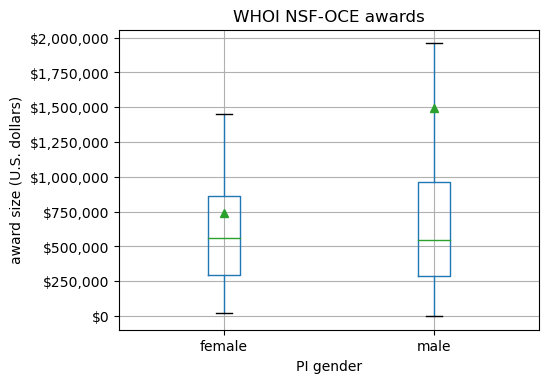

In [6]:
fig, ax = plt.subplots()
_ = whoi_awards.boxplot('tot_amount_adjusted', by='PI_gender', showfliers=False, showmeans=True, ax=ax)
_ = ax.yaxis.set_major_formatter(fmt)
_ = ax.set(title='WHOI NSF-OCE awards', xlabel='PI gender', ylabel='award size (U.S. dollars)')
fig.suptitle('')
fig.subplots_adjust(left=0.2)

Box plot of the amount awarded to individual projects by male and female PIs in each year.

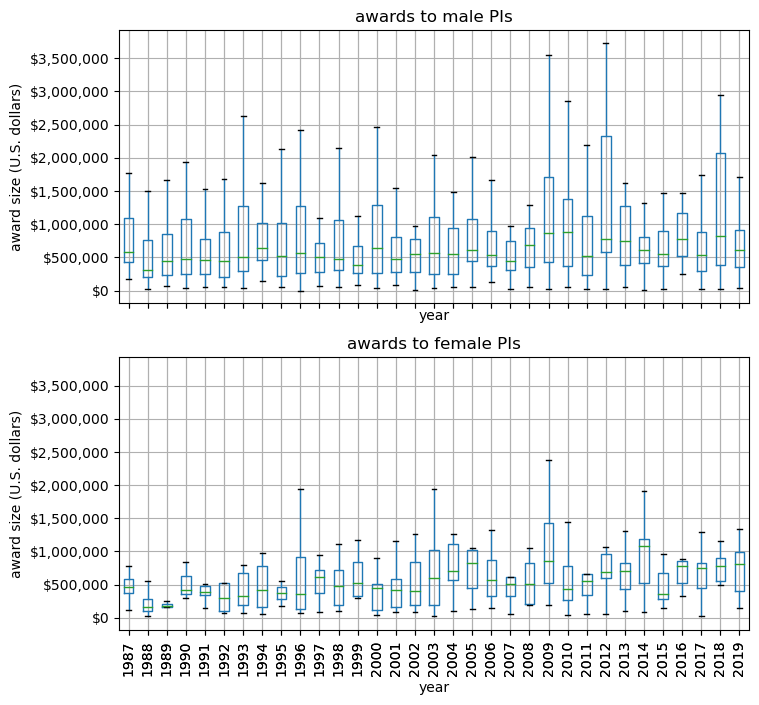

In [7]:
whoi_awards_male['year'] = whoi_awards_male.StartDate.dt.year
whoi_awards_female['year'] = whoi_awards_female.StartDate.dt.year
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(9,8))
_ = whoi_awards_male.boxplot('tot_amount_adjusted', by='year', showfliers=False, rot=90, ax=axs[0])
_ = whoi_awards_female.boxplot('tot_amount_adjusted', by='year', showfliers=False, rot=90, ax=axs[1])
axs[0].set_title('awards to male PIs')
axs[1].set_title('awards to female PIs')
for n in range(2):
    _ = axs[n].yaxis.set_major_formatter(fmt)
    _ = axs[n].set(ylabel='award size (U.S. dollars)')
fig.suptitle('')
fig.subplots_adjust(left=0.2)

Time series of median award size to male and female PIs.

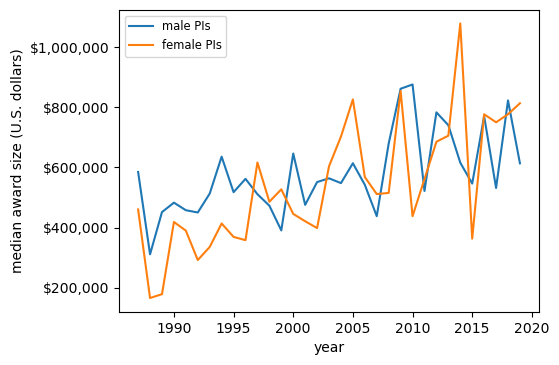

In [8]:
whoi_median_award = pd.DataFrame({'male PIs': whoi_awards_male.groupby('year')['tot_amount_adjusted'].median(),
                                  'female PIs': whoi_awards_female.groupby('year')['tot_amount_adjusted'].median()})
fig, ax = plt.subplots()
_ = whoi_median_award.plot(ax=ax)
_ = ax.set(ylabel='median award size (U.S. dollars)')
_ = ax.yaxis.set_major_formatter(fmt)
fig.subplots_adjust(left=0.2)

t-test for equal means

In [9]:
import statsmodels.api as sm
male = whoi_awards_male.tot_amount_adjusted.values
female = whoi_awards_female.tot_amount_adjusted.values
tstat, pval, df = sm.stats.ttest_ind(male, female)
print('t={:.3f}, p={:.3f}, df={:.0f}'.format(tstat, pval, df))

t=2.516, p=0.012, df=1598


The figure below shows the time series of the annual fraction of female PIs and co-PIs across all WHOI awards. Solid lines represent a 3-year sliding window average and points represent the individual years.

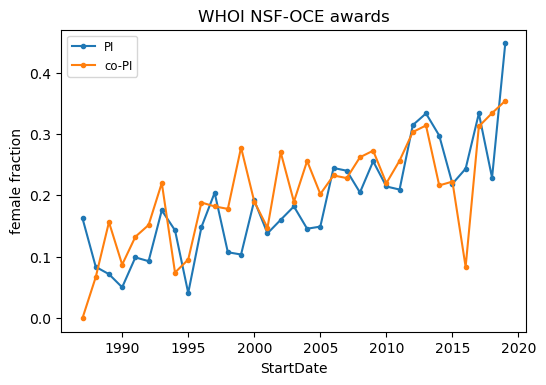

In [10]:
# female & male fraction of PIs
whoi_pi_gender = whoi_awards.groupby([whoi_awards.StartDate.dt.year,
                                      'PI_gender'])['Abstract'].count().unstack()
whoi_pi_gender = whoi_pi_gender.divide(whoi_pi_gender.sum(axis=1), axis=0)

# female & male fraction of co-PIs
whoi_copi_gender = pd.DataFrame({'female':whoi_awards.groupby(whoi_awards.StartDate.dt.year)
                                 ['co-PI_female_frac'].mean()})
whoi_copi_gender['male'] = 1 - whoi_copi_gender.female

# female fraction of PIs & co-PIs
whoi_female_frac = pd.DataFrame({'PI':whoi_pi_gender['female'], 'co-PI':whoi_copi_gender['female']})
fig, ax = plt.subplots()
_ = whoi_female_frac.plot(ax=ax, style='.-')
# _ = whoi_female_frac.plot(ax=ax, style=['C0.','C1.'],legend=False, alpha=0.5)
# _ = whoi_female_frac.rolling(3,center=True).mean().plot(ax=ax)
_ = ax.set(title='WHOI NSF-OCE awards',ylabel='female fraction')

Linear trends fit the data reasonably well.

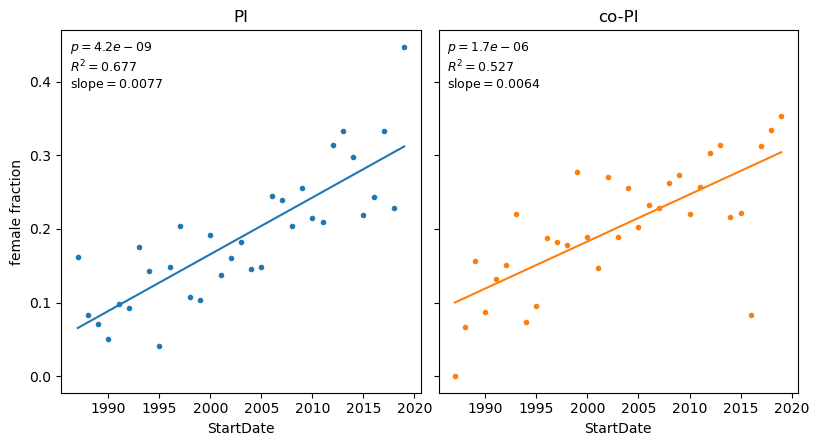

In [11]:
import statsmodels.api as sm
import seaborn as sns

def linreg(x, y):
    X = sm.add_constant(x)
    lreg = sm.OLS(y,X).fit()
    return lreg, X

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9.5, 4.8))
fig.subplots_adjust(wspace=0.05, hspace=0.15)

_ = whoi_female_frac.PI.plot(ax=axs[0], style='C0.')
_ = axs[0].set(title='PI', ylabel='female fraction')

_ = whoi_female_frac['co-PI'].plot(ax=axs[1], style='C1.')
_ = axs[1].set(title='co-PI', ylabel='female fraction')

for ax, x, y, s in zip(axs.ravel(),[whoi_female_frac.index, whoi_female_frac.index],
                       [whoi_female_frac.PI, whoi_female_frac['co-PI']],['C0-','C1-']):
    reg, X = linreg(x, y)
    p, slope, rsquared = reg.pvalues[1], reg.params[1], reg.rsquared
    _ = ax.plot(x, reg.predict(X), s)
    _ = ax.text(0.025,0.95, '$p={:.2g}$'.format(p), transform=ax.transAxes, ha='left',
                va='center', fontsize=9)
    _ = ax.text(0.025,0.90, '$R^2={:.3g}$'.format(rsquared), transform=ax.transAxes, ha='left',
                va='center', fontsize=9)
    _ = ax.text(0.025,0.85, 'slope$={:.2g}$'.format(slope), transform=ax.transAxes, ha='left',
                va='center', fontsize=9)

We use a multivariate linear regression of *female fraction* on *time* (year), *category* (PI or co-PI) plus an interaction term (*time* $\times$ *category*) to test whether the temporal trend (slope) and the mean female fraction (intercept) are different between PIs and co-PIs. The table below shows the results from the multivariate linear regression. The large $p$ values for *category* and the interaction term indicate that the differences in intercept and regression slope between PIs and co-PIs are not statistically significant.

In [12]:
import statsmodels.formula.api as smf

df_pi = pd.DataFrame({'fem_frac':whoi_female_frac['PI'], 'category':'PI'})
df_copi = pd.DataFrame({'fem_frac':whoi_female_frac['co-PI'], 'category':'co-PI'})
df = pd.concat([df_pi,df_copi]).reset_index()
df = df.rename(columns={'StartDate':'year'})
lreg = smf.ols(formula='fem_frac ~ year + category + year:category', data=df)
res = lreg.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               fem_frac   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     32.22
Date:                Tue, 10 Nov 2020   Prob (F-statistic):           1.12e-12
Time:                        15:42:37   Log-Likelihood:                 98.729
No. Observations:                  66   AIC:                            -189.5
Df Residuals:                      62   BIC:                            -180.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                -15.2434      2.048     -7.442      0.000     -19.338     -11.149
category[T.co-PI]          2.6649      2.897      0.920      0.361      -3.125       8.455
year                       0.0077      0.001      7.534      0.000       0.006       0.010
year:category[T.co-PI]    -0.0013      0.001     -0.915      0.364      -0.004       0.002
==============================================================================
Omnibus:                        8.447   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.015   Jarque-Bera (JB):               10.482
Skew:                          -0.507   Prob(JB):                      0.00530
Kurtosis:                       4.668   Cond. No.                     1.10e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Combining the PI and co-PI data we get the regression:

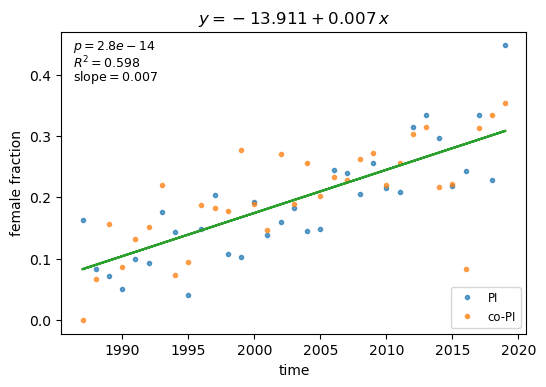

In [13]:
# df  = pd.concat([df_pi,df_copi]).reset_index()
lreg_all, X = linreg(df.year, df.fem_frac)
fig, ax = plt.subplots()
_ = ax.plot(df_pi.index, df_pi.fem_frac,'.', label='PI', alpha=0.7)
_ = ax.plot(df_copi.index, df_copi.fem_frac,'.', label='co-PI', alpha=0.7)
_ = ax.plot(df.year, lreg_all.predict(X))
_ = ax.legend(loc='lower right')
p, slope, rsquared = lreg_all.pvalues[1], lreg_all.params[1], lreg_all.rsquared
a, b = lreg_all.params
title = '$y = {:.3f} + {:.2g}\,x$'.format(a, b)
_ = ax.text(0.025,0.95, '$p={:.2g}$'.format(p), transform=ax.transAxes, ha='left',
            va='center', fontsize=9)
_ = ax.text(0.025,0.90, '$R^2={:.3g}$'.format(rsquared), transform=ax.transAxes, ha='left',
            va='center', fontsize=9)
_ = ax.text(0.025,0.85, 'slope$={:.2g}$'.format(slope), transform=ax.transAxes, ha='left',
            va='center', fontsize=9)
_ = ax.set(xlabel='time', ylabel='female fraction', title=title)

## NSF programs

### Top 10 programs in number of awards at WHOI

The table and histogram below show the top 10 NSF-OCE programs at WHOI in number of awards for the period 1987-2019.

,number of awards,percentage of total,cum percentage of total
program,,,
MARINE GEOLOGY AND GEOPHYSICS,398,3.456962,3.456962
PHYSICAL OCEANOGRAPHY,353,3.066099,6.523061
CHEMICAL OCEANOGRAPHY,223,1.936941,8.460002
BIOLOGICAL OCEANOGRAPHY,212,1.841397,10.301398
OCEAN TECH & INTERDISC COORDIN,100,0.868583,11.169982
OCEANOGRAPHIC INSTRUMENTATION,47,0.408234,11.578216
SHIPBOARD SCIENTIFIC SUPP EQUI,37,0.321376,11.899592
OCEAN DRILLING PROGRAM,32,0.277947,12.177538
MAJOR RESEARCH INSTRUMENTATION,21,0.182403,12.359941


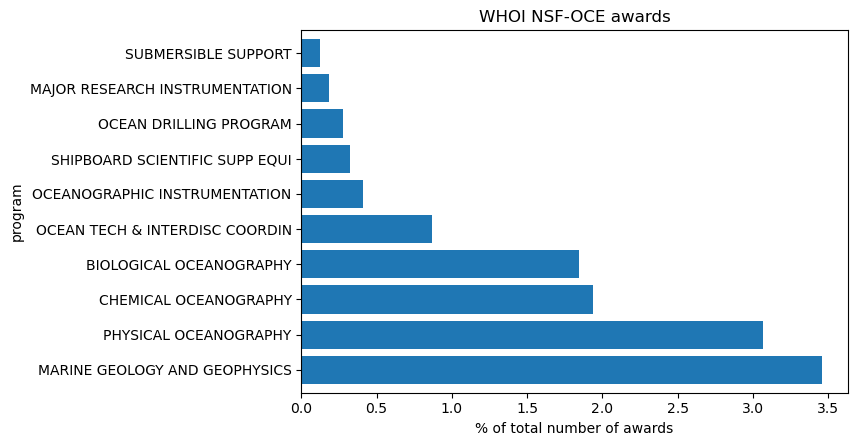

In [14]:
whoi_top10_programs = pd.DataFrame({'number of awards':
                                    whoi_awards.groupby('program')['Abstract'].count().sort_values(
                                        ascending=False)[:10]})
whoi_top10_programs['percentage of total'] = whoi_top10_programs['number of awards'] / len(awards) * 100
whoi_top10_programs['cum percentage of total'] = whoi_top10_programs['percentage of total'].cumsum() 

fig, ax = plt.subplots(figsize=(9.5, 4.8))
fig.subplots_adjust(left=0.325)
_ = whoi_top10_programs['percentage of total'].plot(kind='barh',ax=ax, width=0.8)
_ = ax.set(title='WHOI NSF-OCE awards', xlabel='% of total number of awards')

whoi_top10_programs

Boxplot of award size by program.

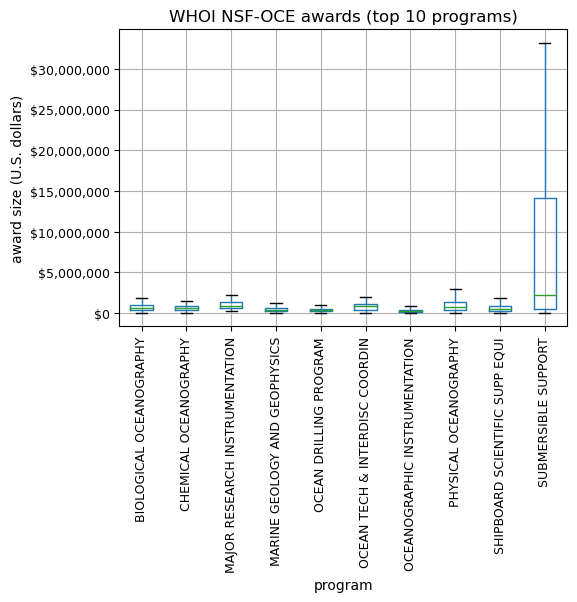

In [15]:
df = whoi_awards[whoi_awards.program.isin(whoi_top10_programs.index)]
fig, ax = plt.subplots(figsize=(6.4, 6.6))
_ = df.boxplot('tot_amount_adjusted', by='program', showfliers=False, rot=90, fontsize=9, ax=ax)
_ = ax.yaxis.set_major_formatter(fmt)
_ = ax.set(title='WHOI NSF-OCE awards (top 10 programs)', ylabel='award size (U.S. dollars)')
fig.suptitle('')
fig.subplots_adjust(left=0.2, bottom=0.45)

Boxplot of award interdisciplinarity by program.

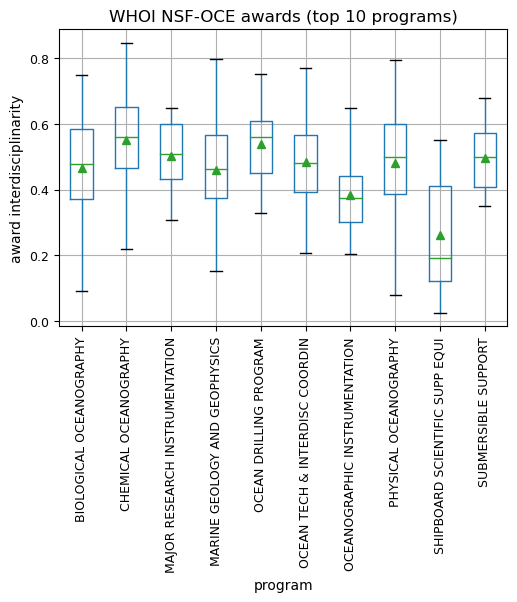

In [16]:
fig, ax = plt.subplots(figsize=(6.4, 6.6))
_ = df.boxplot('evenness', by='program', showfliers=False, showmeans=True,
               rot=90, fontsize=9, ax=ax)
_ = ax.set(title='WHOI NSF-OCE awards (top 10 programs)', ylabel='award interdisciplinarity')
fig.suptitle('')
fig.subplots_adjust(left=0.2, bottom=0.45)

The figure below shows time series of the percentage of awards per year for each of the top 10 NSF-OCE programs at WHOI (in number of awards).

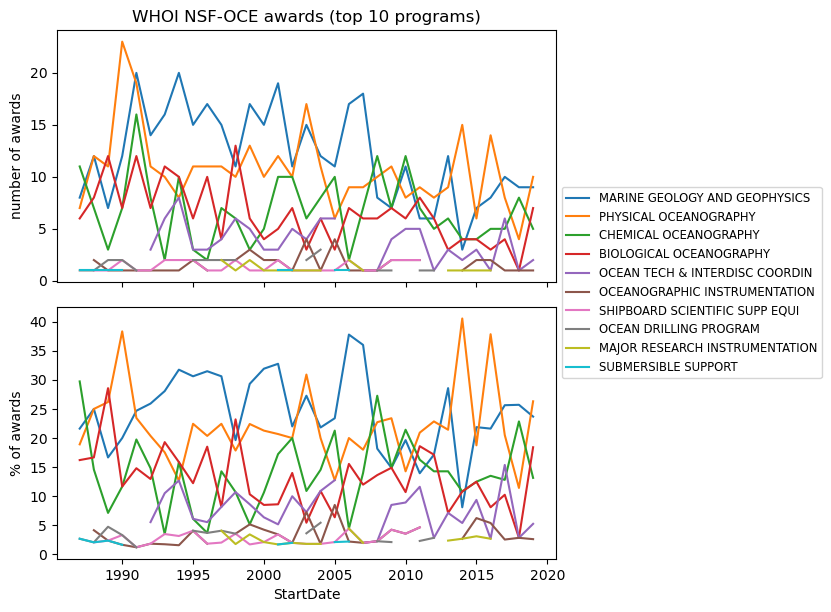

In [17]:
whoi_prog_year = whoi_awards.groupby([whoi_awards.StartDate.dt.year,'program'])['Abstract'].count().unstack()
whoi_prog_year = whoi_prog_year[whoi_top10_programs.index]
whoi_prog_year_pct = whoi_prog_year.divide(num_awards_per_year_whoi, axis=0) * 100

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(9.5,7))
fig.subplots_adjust(right=0.65, hspace=0.1)
_ = whoi_prog_year.plot(ax=axs[0], legend=False)
_ = axs[0].set_ylabel('number of awards')
_ = axs[0].set_title('WHOI NSF-OCE awards (top 10 programs)')
_ = whoi_prog_year_pct.plot(ax=axs[1]).legend(bbox_to_anchor=(1, 1.5))
_ = axs[1].set_ylabel('% of awards')

### Top 10 programs in amount awarded to WHOI

The table and histogram below show the top 10 NSF-OCE programs at WHOI in total amount awarded for the period 1987-2019.

,amount awarded,percentage of total,cum percentage of total
program,,,
PHYSICAL OCEANOGRAPHY,"$488,980,300.89",22.499196,22.499196
MARINE GEOLOGY AND GEOPHYSICS,"$349,974,695.94",16.103204,38.602400
BIOLOGICAL OCEANOGRAPHY,"$299,215,442.45",13.767645,52.370045
CHEMICAL OCEANOGRAPHY,"$155,031,388.07",7.133379,59.503423
SHIP OPERATIONS,"$117,652,906.72",5.413502,64.916925
SUBMERSIBLE SUPPORT,"$110,985,969.24",5.106740,70.023665
OCEAN TECH & INTERDISC COORDIN,"$88,326,099.24",4.064103,74.087768
ARC RSCH SUPPORT & LOGISTICS,"$76,672,826.91",3.527907,77.615675
OCEAN OBSERVATORIES INITIATIVE,"$71,206,955.34",3.276409,80.892083


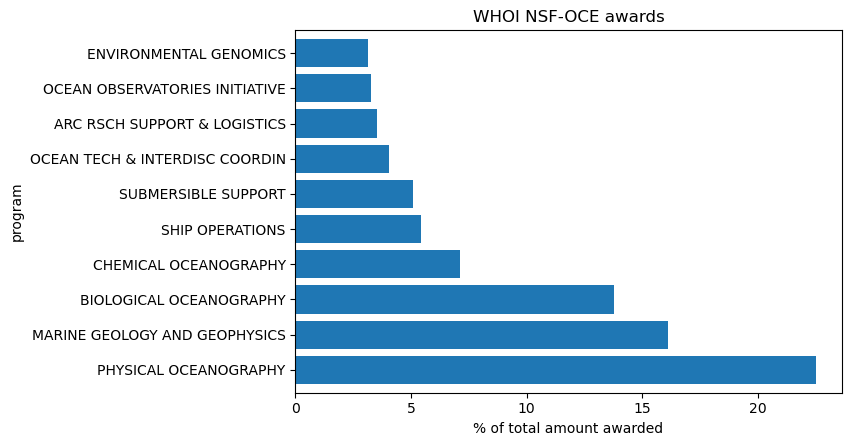

In [18]:
whoi_top10_progs_amount = pd.DataFrame({'amount awarded':
                                        whoi_awards.groupby('program')
                                        ['tot_amount_adjusted'].sum().sort_values(ascending=False)[:10]})
whoi_top10_progs_amount['percentage of total'] = (whoi_top10_progs_amount['amount awarded'] /
                                           whoi_awards.tot_amount_adjusted.sum() * 100)
whoi_top10_progs_amount['cum percentage of total'] = whoi_top10_progs_amount['percentage of total'].cumsum()

fig, ax = plt.subplots(figsize=(9.5, 4.8))
fig.subplots_adjust(left=0.325)
_ = whoi_top10_progs_amount['percentage of total'].plot(kind='barh',ax=ax, width=0.8)
_ = ax.set(title='WHOI NSF-OCE awards', xlabel='% of total amount awarded')

whoi_top10_progs_amount.style.format('${0:,.2f}', subset='amount awarded')

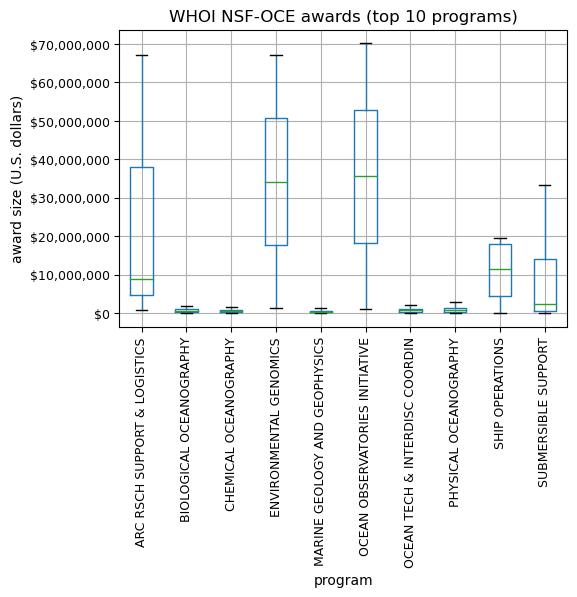

In [19]:
df = whoi_awards[whoi_awards.program.isin(whoi_top10_progs_amount.index)]
fig, ax = plt.subplots(figsize=(6.4, 6.6))
_ = df.boxplot('tot_amount_adjusted', by='program', showfliers=False, rot=90, fontsize=9, ax=ax)
_ = ax.yaxis.set_major_formatter(fmt)
_ = ax.set(title='WHOI NSF-OCE awards (top 10 programs)', ylabel='award size (U.S. dollars)')
fig.suptitle('')
fig.subplots_adjust(left=0.2, bottom=0.45)

The figure below shows time series of the amount awarded per year for each of the top 10 NSF-OCE programs at WHOI (in amount awarded).

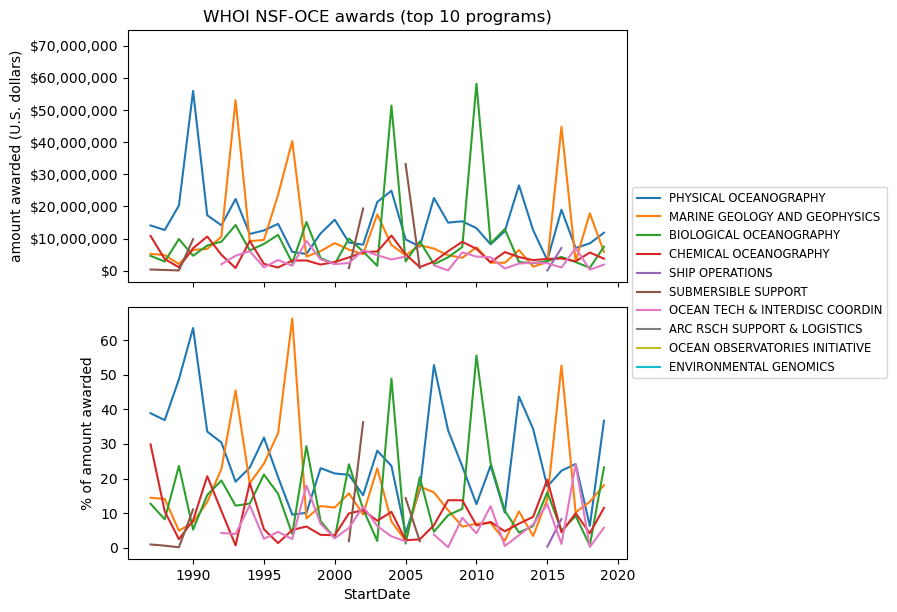

In [20]:
whoi_prog_year_amount = whoi_awards.groupby(
    [whoi_awards.StartDate.dt.year,'program'])['tot_amount_adjusted'].sum().unstack()
whoi_prog_year_amount = whoi_prog_year_amount[whoi_top10_progs_amount.index]
whoi_prog_year_amount_pct = whoi_prog_year_amount.divide(amount_per_year_whoi, axis=0) * 100

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(9.5,7))
fig.subplots_adjust(right=0.65, hspace=0.1)
_ = whoi_prog_year_amount.plot(ax=axs[0], legend=False)
_ = axs[0].set_ylabel('amount awarded (U.S. dollars)')
_ = axs[0].set_title('WHOI NSF-OCE awards (top 10 programs)')
_ = axs[0].yaxis.set_major_formatter(fmt)
_ = whoi_prog_year_amount_pct.plot(ax=axs[1]).legend(bbox_to_anchor=(1, 1.5))
_ = axs[1].set_ylabel('% of amount awarded')

### Gender composition across top 10 programs (in number of awards) at WHOI

PI gender fraction across top 10 programs.

PI_gender,female,male
program,,
BIOLOGICAL OCEANOGRAPHY,0.259434,0.740566
MAJOR RESEARCH INSTRUMENTATION,0.238095,0.761905
MARINE GEOLOGY AND GEOPHYSICS,0.195980,0.804020
PHYSICAL OCEANOGRAPHY,0.186969,0.813031
CHEMICAL OCEANOGRAPHY,0.174888,0.825112
SUBMERSIBLE SUPPORT,0.142857,0.857143
OCEAN TECH & INTERDISC COORDIN,0.140000,0.860000
OCEAN DRILLING PROGRAM,0.031250,0.968750
OCEANOGRAPHIC INSTRUMENTATION,0.000000,1.000000


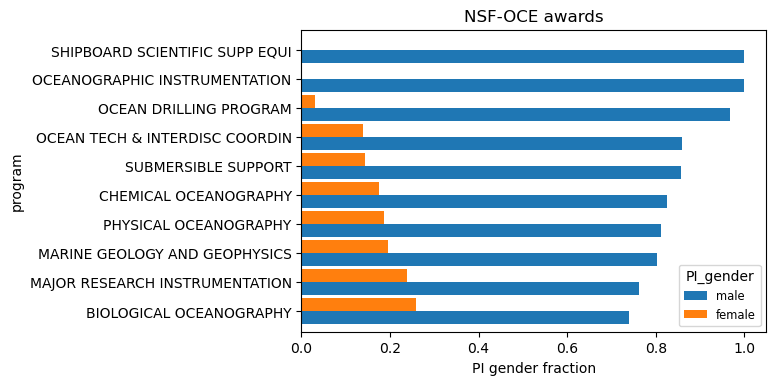

In [21]:
df_prog = whoi_awards[awards.program.isin(whoi_top10_programs.index)]

df = df_prog.groupby(['program','PI_gender'])['Abstract'].count().unstack()
by_program_pi = df.fillna(0).divide(df.sum(axis=1), axis=0)
by_program_pi = by_program_pi.sort_values('male')

fig, ax = plt.subplots()
_ = by_program_pi[['male','female']].plot(kind='barh', ax=ax, width=0.9)
_ = ax.set(title='NSF-OCE awards', xlabel='PI gender fraction')

by_program_pi

co-PI gender fraction across top 10 programs.

,female,male
program,,
SUBMERSIBLE SUPPORT,0.666667,0.333333
BIOLOGICAL OCEANOGRAPHY,0.281884,0.718116
OCEANOGRAPHIC INSTRUMENTATION,0.226190,0.773810
CHEMICAL OCEANOGRAPHY,0.219804,0.780196
PHYSICAL OCEANOGRAPHY,0.207625,0.792375
MARINE GEOLOGY AND GEOPHYSICS,0.196651,0.803349
OCEAN TECH & INTERDISC COORDIN,0.191198,0.808802
MAJOR RESEARCH INSTRUMENTATION,0.179167,0.820833
OCEAN DRILLING PROGRAM,0.033333,0.966667


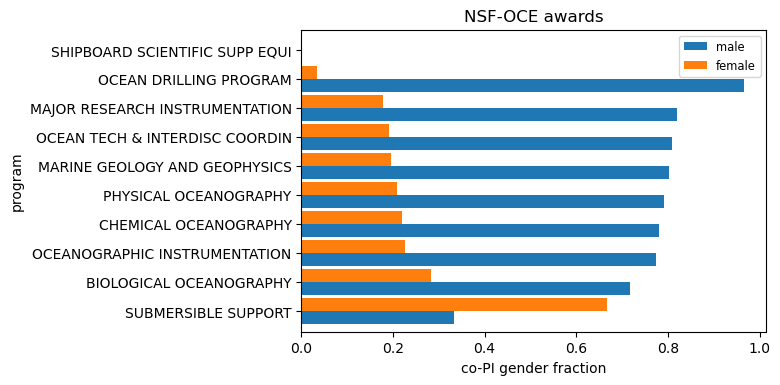

In [22]:
by_program_copi = pd.DataFrame({'female': df_prog.groupby(['program'])['co-PI_female_frac'].mean()})
by_program_copi['male'] = 1 - by_program_copi.female
by_program_copi = by_program_copi.sort_values('male')

fig, ax = plt.subplots()
_ = by_program_copi[['male','female']].plot(kind='barh', ax=ax, width=0.9)
_ = ax.set(title='NSF-OCE awards', xlabel='co-PI gender fraction')

by_program_copi

### Changes in gender composition across top 10 programs (in number of awards) at WHOI

The figure below shows time series of the annual fraction of female PIs and co-PIs for each of the top 10 programs in number of awards at WHOI. Solid lines represent a 3-year sliding window average and points represent the individual years.

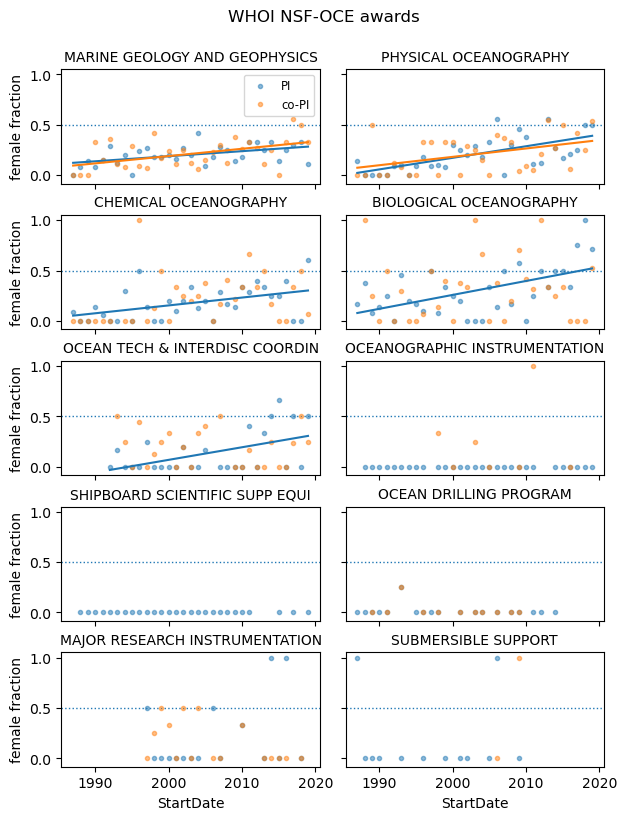

In [23]:
# female & male fraction of PIs
df_prog = whoi_awards[whoi_awards.program.isin(whoi_top10_programs.index)]
df = df_prog.groupby(['program',df_prog.StartDate.dt.year,'PI_gender'])['Abstract'].count().unstack()
whoi_pi_gender_by_program = df.fillna(0).divide(df.sum(axis=1), axis=0)

# female & male fraction of co-PIs
whoi_copi_gender_by_program = pd.DataFrame({'female': 
                                            df_prog.groupby(['program',df_prog.StartDate.dt.year])
                                            ['co-PI_female_frac'].mean()})
whoi_copi_gender_by_program['male'] = 1 - whoi_copi_gender_by_program.female

# female fraction of PIs & co-PIs
whoi_female_frac_by_program = pd.DataFrame({'PI':whoi_pi_gender_by_program['female'],
                                            'co-PI':whoi_copi_gender_by_program['female']})

nn = 3 # size of moving window (years)
alpha = 0.5

fig, axs = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(7, 9))
fig.subplots_adjust(hspace=0.275, wspace=0.1, top=0.9)
params = []
for ax, prog in zip(axs.ravel(), whoi_top10_programs.index):
    if prog == 'MARINE GEOLOGY AND GEOPHYSICS':
        legend = True
    else:
        legend=False
    _ = whoi_female_frac_by_program.loc[prog].plot(ax=ax, style=['C0.','C1.'],legend=legend, alpha=alpha)
#     _ = whoi_female_frac_by_program.loc[prog].rolling(nn, center=True).mean().plot(ax=ax, legend=legend)
    
    y = whoi_female_frac_by_program.loc[prog,'PI'].dropna()
    if y.size > 1:
        reg1, X = linreg(whoi_female_frac_by_program.loc[prog].index, y)
        rs1, sl1, pv1 = reg1.rsquared,reg1.params[1],reg1.pvalues[1]
        if reg1.pvalues[1]<0.05:
            _ = ax.plot(whoi_female_frac_by_program.loc[prog].index, reg1.predict(X), 'C0')
    else:
        rs1, sl1, pv1 = np.nan, np.nan, np.nan

    y = whoi_female_frac_by_program.loc[prog,'co-PI'].dropna()
    if y.size > 1:
        reg2, X = linreg(whoi_female_frac_by_program.loc[prog].dropna().index, y)
        rs2, sl2, pv2 = reg2.rsquared,reg2.params[1],reg2.pvalues[1]
        if reg2.pvalues[1]<0.05:
            _ = ax.plot(whoi_female_frac_by_program.loc[prog].dropna().index, reg2.predict(X), 'C1')
    else:
        rs2, sl2, pv2 = np.nan, np.nan, np.nan
        
    params.append([rs1,sl1,pv1,rs2,sl2,pv2])

    _ = ax.set_title(prog, fontsize=10)
    x0, x1 = ax.get_xlim()
    _ = ax.hlines(0.5, x0, x1, linestyles='dotted', linewidth=1)
    _ = ax.set_xlim(x0,x1)    
for i in range(5):
    _ = axs[i,0].set_ylabel('female fraction')
_ = fig.text(0.5,0.95,'WHOI NSF-OCE awards', ha='center', va='bottom', fontsize=12)

lr_stats = pd.DataFrame(np.array(params), index=whoi_top10_programs.index,
                        columns=[['PI','PI','PI','co-PI','co-PI','co-PI'],
                                 ['R^2','slope','p-value','R^2','slope','p-value']])
lr_stats.style.format('{:.4f}', subset=['PI','co-PI'])

### Differences in gender composition with respect to academic workforce

Using the linear trend for the combined data (PI and co_PI) as reference we compute anomalies that represent how female fraction/representation differs from that in the ocean sciences academic workforce. The figure below shows a stem plot of the anomalies for the top 10 NSF-OCE programs at WHOI. The table shows the sum of the anomalies for each program which is a metric of how each program is performing relative to the academic workforce. Positive and negative values indicate that the program is overperforming and underperforming female representation in the academic workforce, respectively.

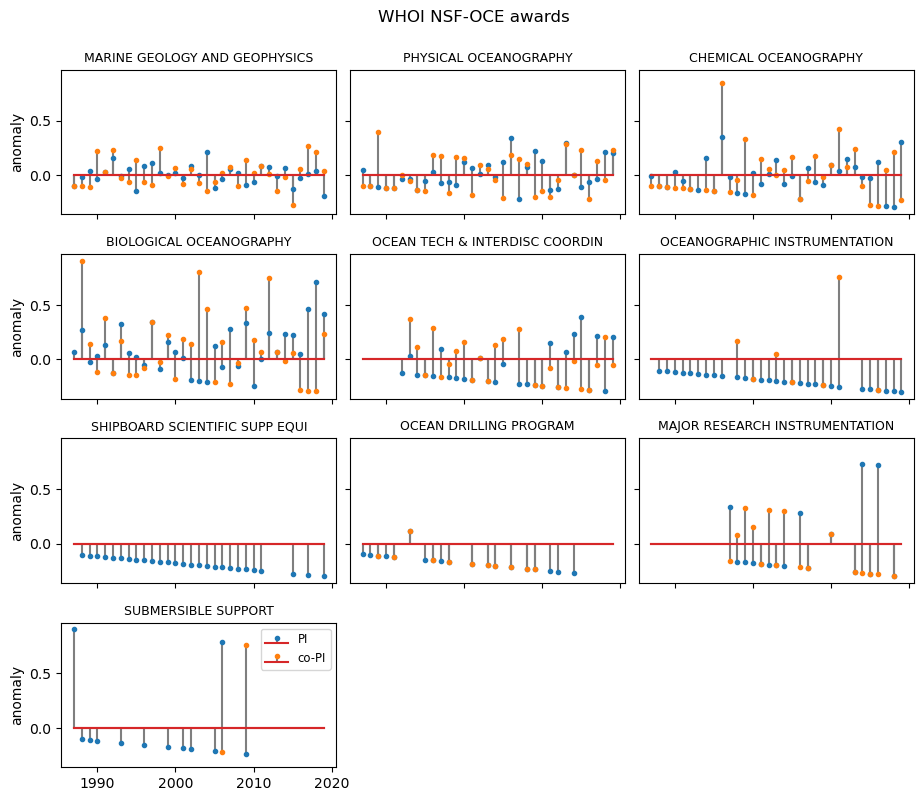

In [24]:
fig, axs = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(11, 9))
fig.delaxes(axs[3,1])
fig.delaxes(axs[3,2])
fig.subplots_adjust(hspace=0.275, wspace=0.05, top=0.9)
params = []
for ax, prog in zip(axs.ravel(), whoi_top10_programs.index):
    if prog == 'MARINE GEOLOGY AND GEOPHYSICS':
        legend = True
    else:
        legend=False
    anom = whoi_female_frac_by_program.loc[prog] - df_ref
#     _ = anom.plot(kind='bar', ax=ax, legend=legend, width=0.95)
    _ = ax.stem(anom.index.values, anom.PI, markerfmt='C0.', linefmt='C7', label='PI')
    _ = ax.stem(anom.index.values, anom['co-PI'], markerfmt='C1.', linefmt='C7', label='co-PI')
    _ = ax.set_title(prog, fontsize=9)
#     ax.xaxis.set_ticks(np.arange(0,33,2))
#     x0, x1 = ax.get_xlim()
#     _ = ax.hlines(0, x0, x1, linestyles='dotted', linewidth=1, colors='k', alpha=0.5)
#     _ = ax.set_xlim(x0,x1)
    params.append([anom.sum()[0], anom.sum()[1]])

_ = ax.legend(loc='best')
for i in range(4):
    _ = axs[i,0].set_ylabel('anomaly')

_ = fig.text(0.5,0.95,'WHOI NSF-OCE awards', ha='center', va='bottom', fontsize=12)

df_anom = pd.DataFrame(data=params, index=whoi_top10_programs.index, columns=[['total sum','total sum'],['PI', 'co-PI']])
df_anom.style.format('{:.3f}')

## Research topics

Similarly to what was done in [Lima & Rheuban, 2018](https://tos.org/oceanography/article/topics-and-trends-in-nsf-ocean-sciences-awards), we applied non-negative matrix factorization (NMF) to the NSF-OCE abstracts to extract 22 research topics.

The table and histogram below show the number of awards and relative frequency of awards per research topic for the period 1987-2019.

,number of awards,percentage of total,cum percentage of total
sensor instrument measurement 12,181,11.3125,11.3125
circulation woce atlantic 13,156,9.7500,21.0625
ridge mantle melt 4,112,7.0000,28.0625
hydrothermal vent fluid 11,109,6.8125,34.8750
shelf coastal transport 22,107,6.6875,41.5625
climate change record 10,106,6.6250,48.1875
microbial phytoplankton cell 18,84,5.2500,53.4375
trace element isotope 14,82,5.1250,58.5625
sediment core margin 20,81,5.0625,63.6250
workshop science international 8,77,4.8125,68.4375


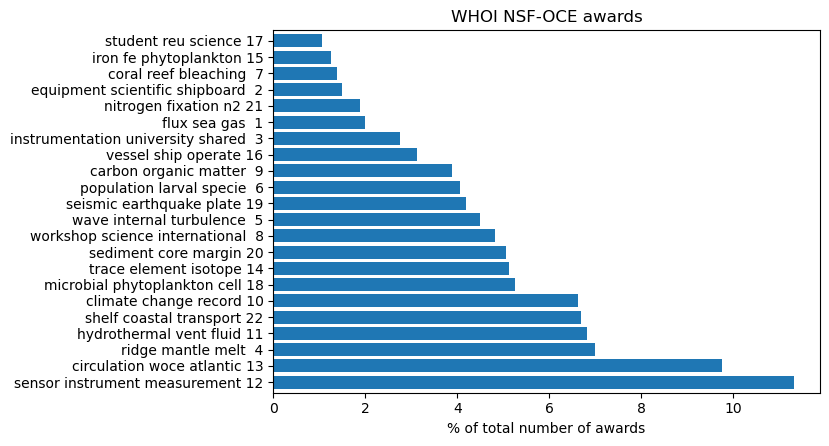

In [25]:
whoi_res_topics = pd.DataFrame({'number of awards':whoi_awards.groupby('topic')['Abstract'].count().sort_values(ascending=False)})
whoi_res_topics.index = topic_names[whoi_res_topics.index.values - 1]
whoi_res_topics['percentage of total'] = whoi_res_topics['number of awards'] / len(whoi_awards) * 100
whoi_res_topics['cum percentage of total'] = whoi_res_topics['percentage of total'].cumsum() 

fig, ax = plt.subplots(figsize=(9.5, 4.8))
fig.subplots_adjust(left=0.325)
_ = whoi_res_topics['percentage of total'].plot(kind='barh',ax=ax, width=0.8)
_ = ax.set(title='WHOI NSF-OCE awards', xlabel='% of total number of awards')

whoi_res_topics

The table and histogram below show the total amount awarded per research topic for the period 1987-2019.

,amount awarded,percentage of total,cum percentage of total
vessel ship operate 16,"$418,911,250.87",19.275146,19.275146
sensor instrument measurement 12,"$311,537,754.54",14.334625,33.609770
workshop science international 8,"$246,680,675.89",11.350390,44.960160
circulation woce atlantic 13,"$223,071,402.22",10.264068,55.224228
shelf coastal transport 22,"$173,934,180.39",8.003143,63.227371
trace element isotope 14,"$89,027,288.57",4.096366,67.323738
instrumentation university shared 3,"$80,206,889.35",3.690518,71.014256
climate change record 10,"$65,259,098.99",3.002733,74.016989
wave internal turbulence 5,"$62,644,049.67",2.882408,76.899397
microbial phytoplankton cell 18,"$61,843,116.56",2.845555,79.744952


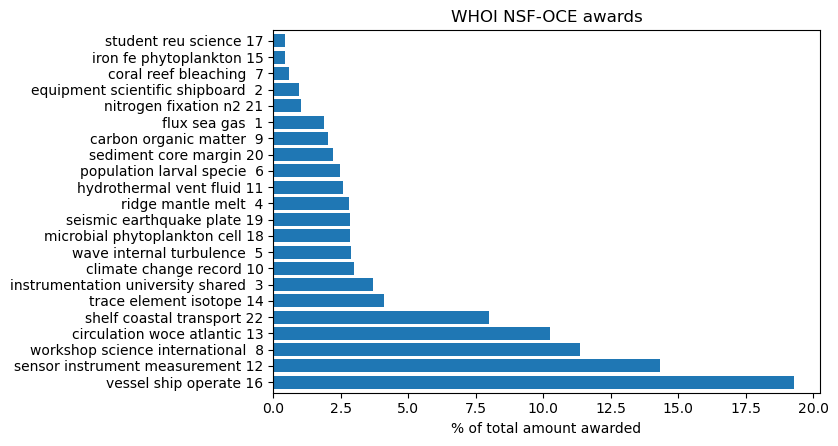

In [26]:
whoi_res_topics_amount = pd.DataFrame({'amount awarded':whoi_awards.groupby('topic')['tot_amount_adjusted'].sum().sort_values(ascending=False)})
whoi_res_topics_amount.index = topic_names[whoi_res_topics_amount.index.values - 1]
whoi_res_topics_amount['percentage of total'] = whoi_res_topics_amount['amount awarded'] / whoi_awards.tot_amount_adjusted.sum() * 100
whoi_res_topics_amount['cum percentage of total'] = whoi_res_topics_amount['percentage of total'].cumsum() 

fig, ax = plt.subplots(figsize=(9.5, 4.8))
fig.subplots_adjust(left=0.325)
_ = whoi_res_topics_amount['percentage of total'].plot(kind='barh',ax=ax, width=0.8)
_ = ax.set(title='WHOI NSF-OCE awards', xlabel='% of total amount awarded')

whoi_res_topics_amount.style.format('${0:,.2f}', subset='amount awarded')

Boxplot of award size by research topic.

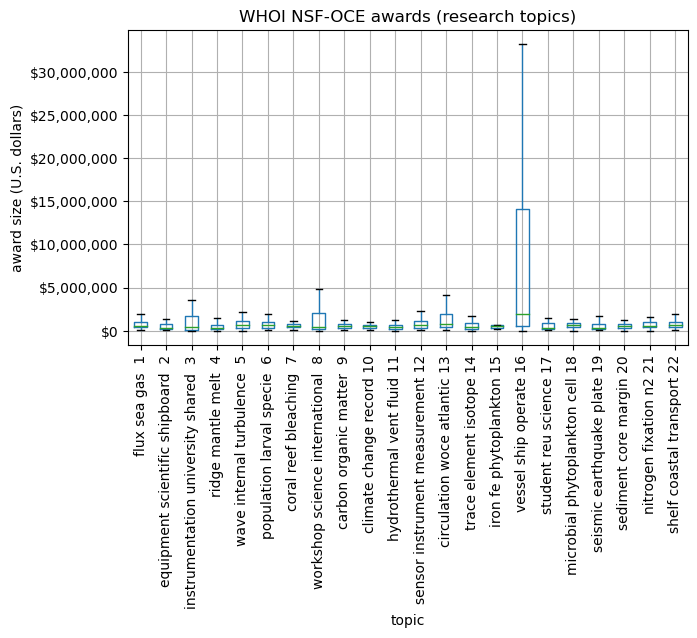

In [27]:
fig, ax = plt.subplots(figsize=(8, 7))
_ = whoi_awards.boxplot('tot_amount_adjusted', by='topic', showfliers=False, rot=90, ax=ax)
_ = ax.yaxis.set_major_formatter(fmt)
_ = ax.set(title='WHOI NSF-OCE awards (research topics)', ylabel='award size (U.S. dollars)', xticklabels=topic_names)
fig.suptitle('')
fig.subplots_adjust(left=0.2, bottom=0.45)

Boxplot of award interdisciplinarity by research topic.

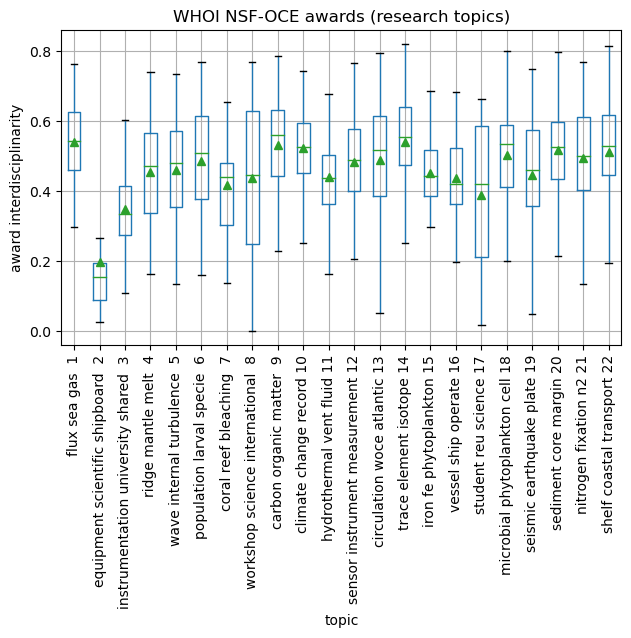

In [28]:
fig, ax = plt.subplots(figsize=(8, 7))
_ = whoi_awards.boxplot('evenness', by='topic', showfliers=False, showmeans=True, rot=90, ax=ax)
_ = ax.set(title='WHOI NSF-OCE awards (research topics)', ylabel='award interdisciplinarity', xticklabels=topic_names)
fig.suptitle('')
fig.subplots_adjust(left=0.2, bottom=0.45)

### Gender composition across research topics at WHOI

PI gender fraction across research topics.

PI_gender,female,male
topic,,
7,0.727273,0.272727
17,0.352941,0.647059
9,0.338710,0.661290
11,0.321101,0.678899
6,0.307692,0.692308
10,0.292453,0.707547
18,0.261905,0.738095
21,0.233333,0.766667
13,0.179487,0.820513


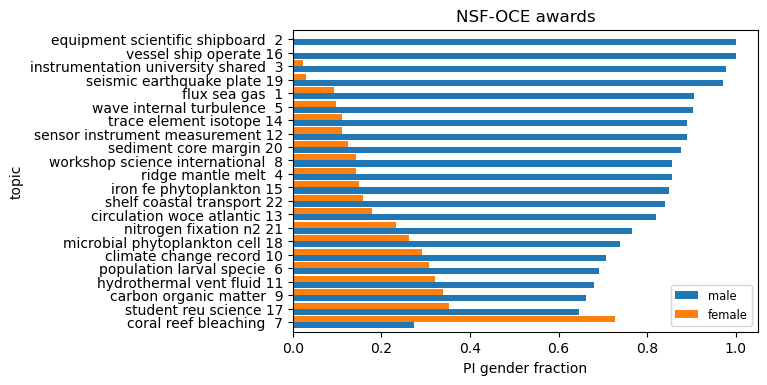

In [29]:
df = whoi_awards.groupby(['topic','PI_gender'])['Abstract'].count().unstack()
by_topic_pi = df.fillna(0).divide(df.sum(axis=1), axis=0)
by_topic_pi = by_topic_pi.sort_values('male')

fig, ax = plt.subplots()
_ = by_topic_pi[['male','female']].plot(kind='barh', ax=ax, width=0.9).legend(bbox_to_anchor=(0.8, 0.175))
_ = ax.set(title='NSF-OCE awards', xlabel='PI gender fraction')
_ = ax.set_yticklabels(topic_names[by_topic_pi.index.values-1])

by_topic_pi

co-PI gender fraction across research topics.

,female,male
topic,,
17,0.541667,0.458333
21,0.433333,0.566667
15,0.409091,0.590909
18,0.338435,0.661565
16,0.333333,0.666667
9,0.314719,0.685281
13,0.311518,0.688482
7,0.300000,0.700000
10,0.290556,0.709444


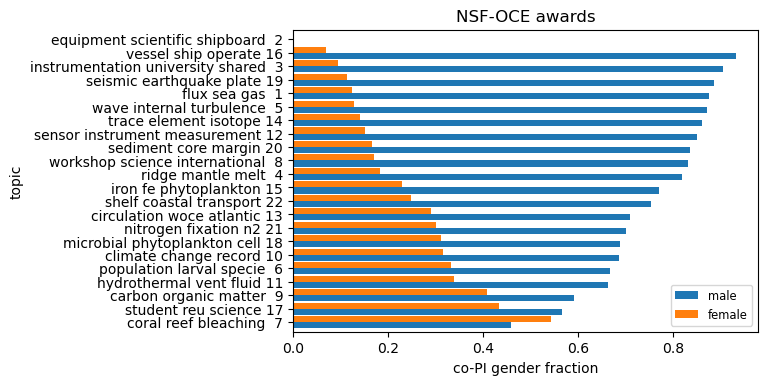

In [30]:
by_topic_copi = pd.DataFrame({'female':whoi_awards.groupby(['topic'])['co-PI_female_frac'].mean()})
by_topic_copi['male'] = 1 - by_topic_copi.female
by_topic_copi = by_topic_copi.sort_values('male')

fig, ax = plt.subplots()
_ = by_topic_copi[['male','female']].plot(kind='barh', ax=ax, width=0.9).legend(bbox_to_anchor=(0.8, 0.175))
_ = ax.set(title='NSF-OCE awards', xlabel='co-PI gender fraction')
_ = ax.set_yticklabels(topic_names[by_topic_pi.index.values-1])

by_topic_copi

### Changes in gender composition across research topics at WHOI

The figure below shows time series of the annual fraction of female PIs and co-PIs for each of the research topics at WHOI. Solid lines represent a 3-year sliding window average and points represent the individual years. The number of awards per year in each topic is small (<10), therefore the high variability from year to year.

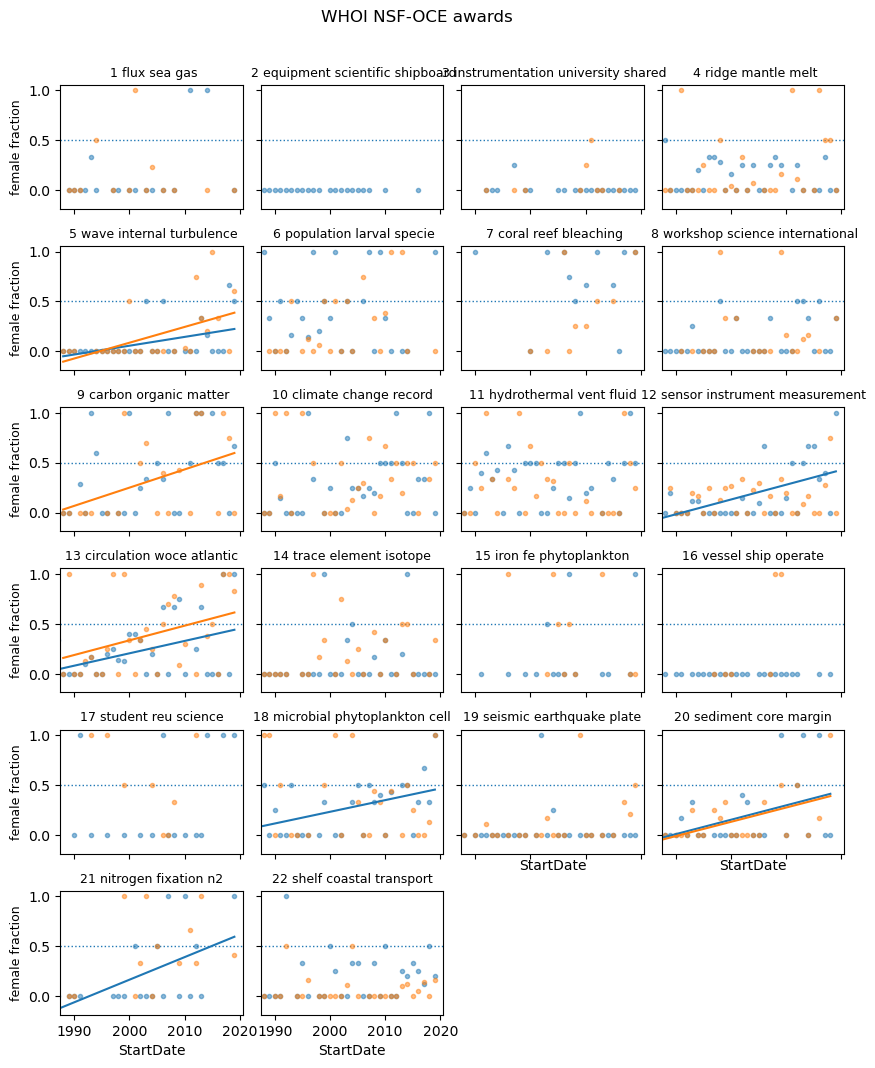

In [31]:
df = whoi_awards.groupby(['topic',whoi_awards.StartDate.dt.year,'PI_gender'])['Abstract'].count().unstack()
whoi_pi_gender_by_topic = df.fillna(0).divide(df.sum(axis=1), axis=0)

whoi_copi_gender_by_topic = pd.DataFrame(
    {'female':whoi_awards.groupby(['topic', whoi_awards.StartDate.dt.year])['co-PI_female_frac'].mean()})
whoi_copi_gender_by_topic['male'] = 1 - whoi_copi_gender_by_topic.female
whoi_copi_gender_by_topic

whoi_female_frac_by_topic = pd.DataFrame({'PI':whoi_pi_gender_by_topic.female,
                                          'co-PI':whoi_copi_gender_by_topic.female})

fig, axs = plt.subplots(6, 4, sharex=True, sharey=True, figsize=(9.5,12))
fig.subplots_adjust(hspace=0.3, wspace=0.1, top=0.9, right=0.95)
fig.delaxes(axs[5,3])
fig.delaxes(axs[5,2])
params = []
for ax, t in zip(axs.ravel(), range(1,23)):
    if t == 2:
        legend = True
    else:
        legend=False    
    _ = whoi_female_frac_by_topic.loc[t].plot(ax=ax, style=['C0.','C1.'], legend=False, alpha=alpha)
#     _ = whoi_female_frac_by_topic.loc[t].rolling(nn,center=True).mean().plot(ax=ax, legend=legend)

    y = whoi_female_frac_by_topic.loc[t,'PI'].dropna()
    if y.size > 1:
        reg1, X = linreg(whoi_female_frac_by_topic.loc[t].index, y)
        rs1, sl1, pv1 = reg1.rsquared,reg1.params[1],reg1.pvalues[1]
        if reg1.pvalues[1]<0.05:
            _ = ax.plot(whoi_female_frac_by_topic.loc[t].index, reg1.predict(X), 'C0')
    else:
        rs1, sl1, pv1 = np.nan, np.nan, np.nan

    y = whoi_female_frac_by_topic.loc[t,'co-PI'].dropna()
    if y.size > 1:
        reg2, X = linreg(whoi_female_frac_by_topic.loc[t].dropna().index, y)
        rs2, sl2, pv2 = reg2.rsquared,reg2.params[1],reg2.pvalues[1]
        if reg2.pvalues[1]<0.05:
            _ = ax.plot(whoi_female_frac_by_topic.loc[t].dropna().index, reg2.predict(X), 'C1')
    else:
        rs2, sl2, pv2 = np.nan, np.nan, np.nan
        
    params.append([rs1,sl1,pv1,rs2,sl2,pv2])

    _ = ax.set_title(topic_names_r[t-1], fontsize=9)
    x0, x1 = ax.get_xlim()
    _ = ax.hlines(0.5, x0, x1, linestyles='dotted', linewidth=1)
    _ = ax.set_xlim(x0,x1)
for i in range(6):
    _ = axs[i,0].set_ylabel('female fraction', fontsize=9)
_ = fig.text(0.5,0.95,'WHOI NSF-OCE awards', ha='center', va='bottom', fontsize=12)

lr_stats = pd.DataFrame(np.array(params), index=topic_names_r,
                        columns=[['PI','PI','PI','co-PI','co-PI','co-PI'],
                                 ['R^2','slope','p-value','R^2','slope','p-value']])
lr_stats.style.format('{:.4f}', subset=['PI','co-PI'])

### Differences in gender composition with respect to academic workforce

Using the linear trend for the combined data (PI and co_PI) as reference we compute anomalies that represent how female fraction/representation differs from that in the ocean sciences academic workforce. The figure below shows a stem plot of the anomalies for the identified research topic. The table shows the sum of the anomalies for each topic which is a metric of how each topic is performing relative to the academic workforce. Positive and negative values indicate that the topic is overperforming and underperforming female representation in the academic workforce, respectively.

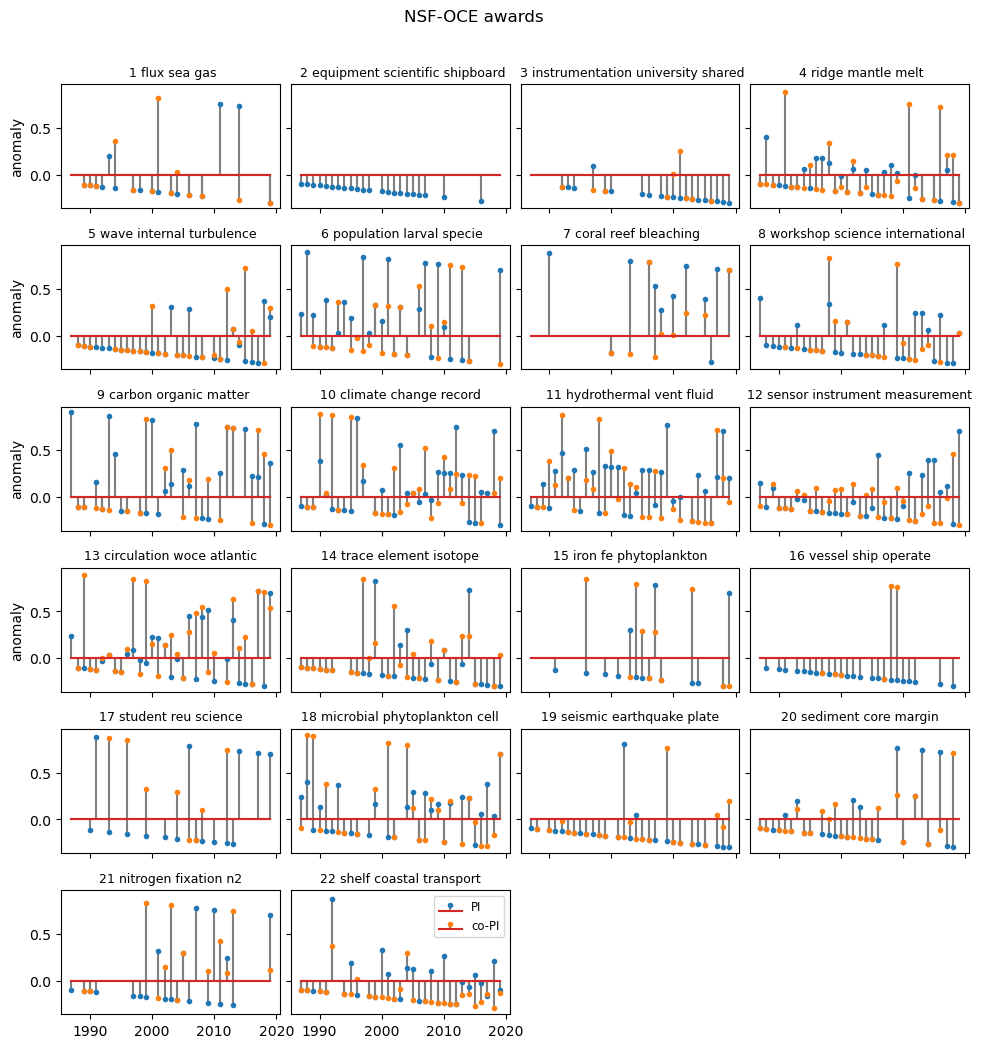

In [32]:
fig, axs = plt.subplots(6, 4, sharex=True, sharey=True, figsize=(11,12))
fig.subplots_adjust(hspace=0.3, wspace=0.05, top=0.9, right=0.95)
fig.delaxes(axs[5,3])
fig.delaxes(axs[5,2])
params = []
for ax, t in zip(axs.ravel(), range(1,23)):
    if t == 2:
        legend = True
    else:
        legend=False
    anom = whoi_female_frac_by_topic.loc[t] - df_ref
    _ = ax.stem(anom.index.values, anom.PI, markerfmt='C0.', linefmt='C7', label='PI')
    _ = ax.stem(anom.index.values, anom['co-PI'], markerfmt='C1.', linefmt='C7', label='co-PI')
    _ = ax.set_title(topic_names_r[t-1], fontsize=9)
    params.append([anom.sum()[0], anom.sum()[1]])

for i in range(4):
    _ = axs[i,0].set_ylabel('anomaly')

_ = ax.legend(loc='best')
_ = fig.text(0.5,0.95,'NSF-OCE awards', ha='center', va='bottom', fontsize=12)

df_anom = pd.DataFrame(data=params, index=topic_names_r, columns=[['total sum','total sum'],['PI', 'co-PI']])
df_anom.style.format('{:.3f}')

## Award types

,number of awards,percentage of total,cum percentage of total
standard,1255,78.4375,78.4375
Collaborative Research,259,16.1875,94.6250
EAGER,42,2.6250,97.2500
RAPID,22,1.3750,98.6250
REU,12,0.7500,99.3750
CAREER,5,0.3125,99.6875
CMG,3,0.1875,99.8750
POWRE,1,0.0625,99.9375
RUI,1,0.0625,100.0000


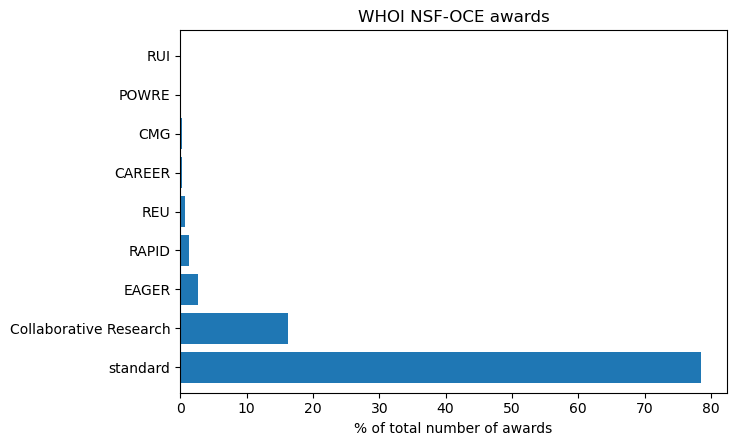

In [33]:
atypes_whoi = pd.DataFrame({'number of awards': whoi_awards.award_type.value_counts()})
atypes_whoi['percentage of total'] =  atypes_whoi['number of awards'] / len(whoi_awards) * 100
atypes_whoi['cum percentage of total'] = atypes_whoi['percentage of total'].cumsum()

fig, ax = plt.subplots(figsize=(9.5, 4.8))
fig.subplots_adjust(left=0.325)
_ = atypes_whoi['percentage of total'].plot(kind='barh',ax=ax, width=0.8)
_ = ax.set(title='WHOI NSF-OCE awards', xlabel='% of total number of awards')

atypes_whoi

,amount awarded,percentage of total,cum percentage of total
award_type,,,
standard,"$1,825,733,906.42",84.006545,84.006545
Collaborative Research,"$320,824,301.72",14.761922,98.768467
REU,"$8,677,883.79",0.399291,99.167758
RAPID,"$5,123,242.16",0.235733,99.403491
EAGER,"$4,525,663.93",0.208237,99.611728
CAREER,"$4,421,981.64",0.203466,99.815194
CMG,"$3,158,872.84",0.145348,99.960542
RUI,"$739,059.74",0.034006,99.994548
POWRE,"$118,495.98",0.005452,100.000000


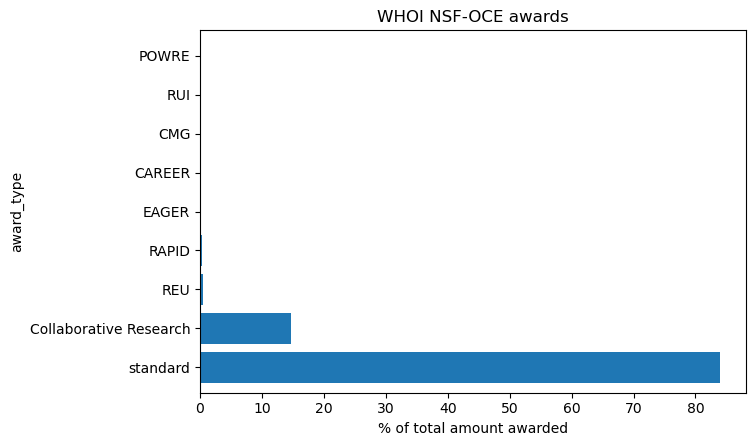

In [34]:
atype_whoi_amount = pd.DataFrame(
    {'amount awarded':
     whoi_awards.groupby('award_type')['tot_amount_adjusted'].sum().sort_values(ascending=False)})
atype_whoi_amount['percentage of total'] = (atype_whoi_amount['amount awarded'] / 
                                            atype_whoi_amount['amount awarded'].sum() * 100)
atype_whoi_amount['cum percentage of total'] = atype_whoi_amount['percentage of total'].cumsum()

fig, ax = plt.subplots(figsize=(9.5, 4.8))
fig.subplots_adjust(left=0.325)
_ = atype_whoi_amount['percentage of total'].plot(kind='barh',ax=ax, width=0.8)
_ = ax.set(title='WHOI NSF-OCE awards', xlabel='% of total amount awarded')

atype_whoi_amount.style.format('${0:,.2f}', subset='amount awarded')

Boxplot of award size by award type.

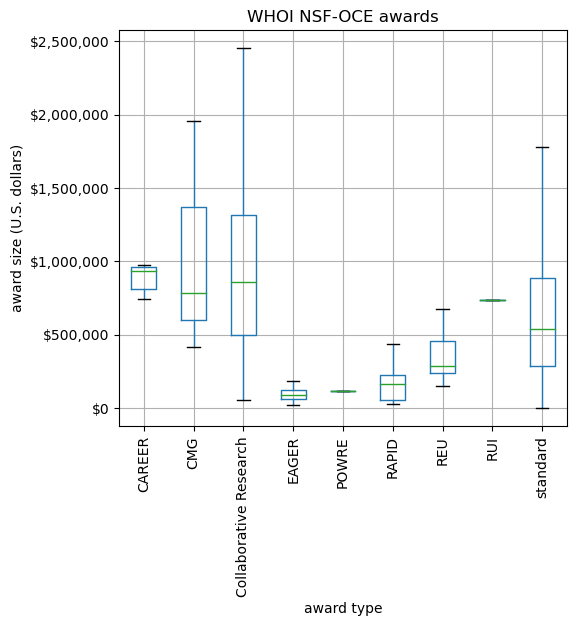

In [35]:
fig, ax = plt.subplots(figsize=(6.4, 6.6))
_ = whoi_awards.boxplot('tot_amount_adjusted', by='award_type', showfliers=False, rot=90, ax=ax)
_ = ax.yaxis.set_major_formatter(fmt)
_ = ax.set(title='WHOI NSF-OCE awards', ylabel='award size (U.S. dollars)', xlabel='award type')
fig.suptitle('')
fig.subplots_adjust(left=0.2, bottom=0.3)

Boxplot of award interdisciplinarity by award type.

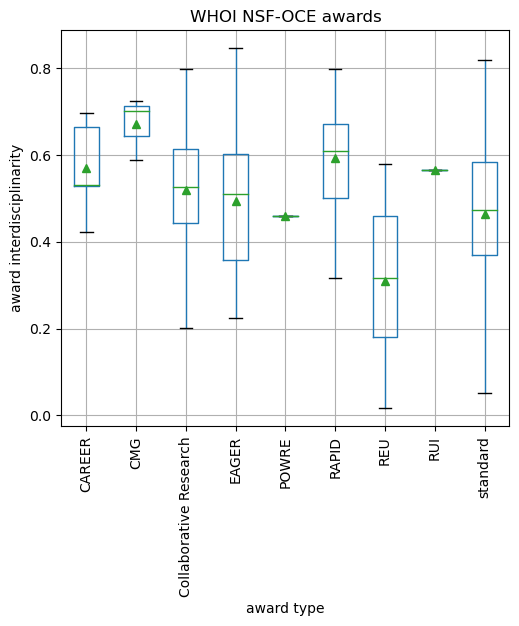

In [36]:
fig, ax = plt.subplots(figsize=(6.4, 6.6))
_ = whoi_awards.boxplot('evenness', by='award_type', showfliers=False, showmeans=True, rot=90, ax=ax)
_ = ax.set(title='WHOI NSF-OCE awards', ylabel='award interdisciplinarity', xlabel='award type')
fig.suptitle('')
fig.subplots_adjust(left=0.2, bottom=0.3)

### Gender composition across award types

PI gender fraction across award types.

PI_gender,female,male
award_type,,
POWRE,1.000000,0.000000
CAREER,0.600000,0.400000
Collaborative Research,0.289575,0.710425
REU,0.250000,0.750000
EAGER,0.190476,0.809524
standard,0.152988,0.847012
RAPID,0.136364,0.863636
CMG,0.000000,1.000000
RUI,0.000000,1.000000


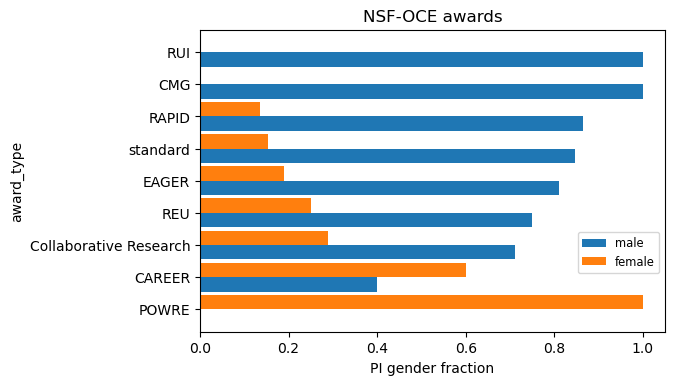

In [37]:
df = whoi_awards.groupby(['award_type','PI_gender'])['Abstract'].count().unstack()
by_atype_pi = df.fillna(0).divide(df.sum(axis=1), axis=0)
by_atype_pi = by_atype_pi.sort_values('male')

fig, ax = plt.subplots()
_ = by_atype_pi[['male','female']].plot(kind='barh', ax=ax, width=0.9).legend(bbox_to_anchor=(0.8, 0.175))
_ = ax.set(title='NSF-OCE awards', xlabel='PI gender fraction')

by_atype_pi

co-PI gender fraction across award types.

,female,male
award_type,,
REU,0.500000,0.500000
RUI,0.500000,0.500000
EAGER,0.323529,0.676471
RAPID,0.277778,0.722222
Collaborative Research,0.225003,0.774997
standard,0.197493,0.802507
CMG,0.166667,0.833333
CAREER,NaN,NaN
POWRE,NaN,NaN


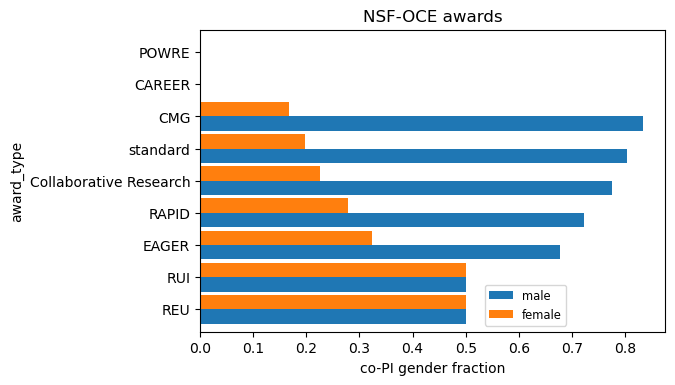

In [38]:
by_atype_copi = pd.DataFrame({'female': whoi_awards.groupby(['award_type'])['co-PI_female_frac'].mean()})
by_atype_copi['male'] = 1 - by_atype_copi.female
by_atype_copi = by_atype_copi.sort_values('male')

fig, ax = plt.subplots()
_ = by_atype_copi[['male','female']].plot(kind='barh', ax=ax, width=0.9).legend(bbox_to_anchor=(0.8, 0.175))
_ = ax.set(title='NSF-OCE awards', xlabel='co-PI gender fraction')

by_atype_copi

### Changes in gender composition across award types

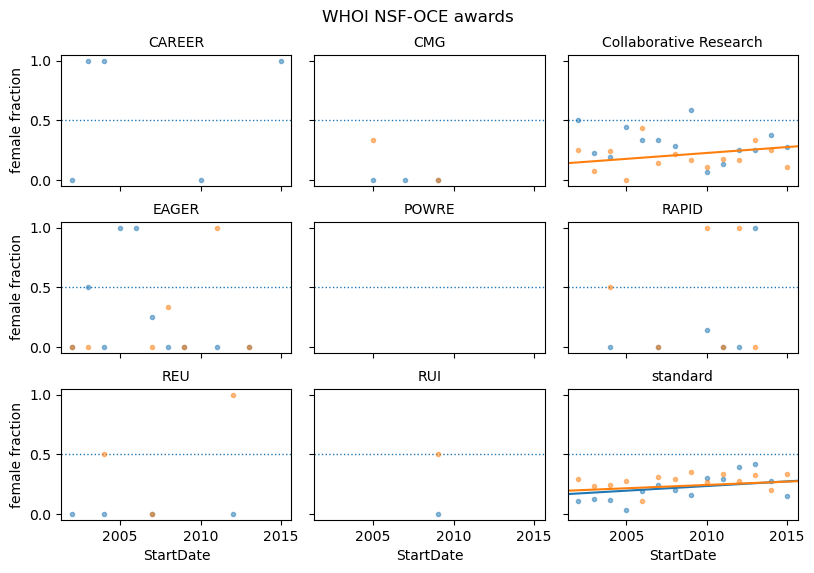

In [39]:
# female & male fraction of PIs
df = whoi_awards.groupby(['award_type',
                          whoi_awards.StartDate.dt.year,'PI_gender'])['Abstract'].count().unstack()
pi_gender_whoi_by_atype = df.fillna(0).divide(df.sum(axis=1), axis=0)

# female & male fraction of co-PIs
copi_gender_whoi_by_atype = pd.DataFrame({
    'female': whoi_awards.groupby(['award_type',whoi_awards.StartDate.dt.year])['co-PI_female_frac'].mean()})
copi_gender_whoi_by_atype['male'] = 1 - copi_gender_whoi_by_atype.female

female_frac_whoi_by_atype = pd.DataFrame({'PI':pi_gender_whoi_by_atype['female'],
                                          'co-PI': copi_gender_whoi_by_atype['female']})

fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(9.5, 6))
fig.subplots_adjust(hspace=0.275, wspace=0.1, top=0.9)
params = []
for ax, atype in zip(axs.ravel(), female_frac_whoi_by_atype.index.levels[0]):
    if atype == 'CMG':
        legend = True
    else:
        legend=False
    _ = female_frac_whoi_by_atype.loc[atype].plot(ax=ax, style=['C0.','C1.'], legend=False, alpha=alpha)
#     _ = female_frac_whoi_by_atype.loc[atype].rolling(nn,center=True).mean().plot(ax=ax, legend=legend)

    y = female_frac_whoi_by_atype.loc[atype,'PI'].dropna()
    if y.size > 1:
        reg1, X = linreg(female_frac_whoi_by_atype.loc[atype].index, y)
        rs1, sl1, pv1 = reg1.rsquared,reg1.params[1],reg1.pvalues[1]
        if reg1.pvalues[1]<0.05:
            _ = ax.plot(female_frac_whoi_by_atype.loc[atype].index, reg1.predict(X), 'C0')
    else:
        rs1, sl1, pv1 = np.nan, np.nan, np.nan

    y = female_frac_whoi_by_atype.loc[atype,'co-PI'].dropna()
    if y.size > 1:
        reg2, X = linreg(female_frac_whoi_by_atype.loc[atype].dropna().index, y)
        rs2, sl2, pv2 = reg2.rsquared,reg2.params[1],reg2.pvalues[1]
        if reg2.pvalues[1]<0.05:
            _ = ax.plot(female_frac_whoi_by_atype.loc[atype].dropna().index, reg2.predict(X), 'C1')
    else:
        rs2, sl2, pv2 = np.nan, np.nan, np.nan
        
    params.append([rs1,sl1,pv1,rs2,sl2,pv2])

    _ = ax.set_title(atype, fontsize=10)
    x0, x1 = ax.get_xlim()
    _ = ax.hlines(0.5, x0, x1, linestyles='dotted', linewidth=1)
    _ = ax.set_xlim(x0,x1)    
for i in range(3):
    _ = axs[i,0].set_ylabel('female fraction')
_ = fig.text(0.5,0.95,'WHOI NSF-OCE awards', ha='center', va='bottom', fontsize=12)

lr_stats = pd.DataFrame(np.array(params), female_frac_whoi_by_atype.index.levels[0],
                        columns=[['PI','PI','PI','co-PI','co-PI','co-PI'],
                                 ['R^2','slope','p-value','R^2','slope','p-value']])
lr_stats.style.format('{:.4f}', subset=['PI','co-PI'])

### Differences in gender composition with respect to academic workforce

Using the linear trend for the combined data (PI and co_PI) as reference we compute anomalies that represent how female fraction/representation differs from that in the ocean sciences academic workforce. The figure below shows a stem plot of the anomalies for the different award type. The table shows the sum of the anomalies for each award type which is a metric of how each award type is performing relative to the academic workforce. Positive and negative values indicate that the award type is overperforming and underperforming female representation in the academic workforce, respectively.

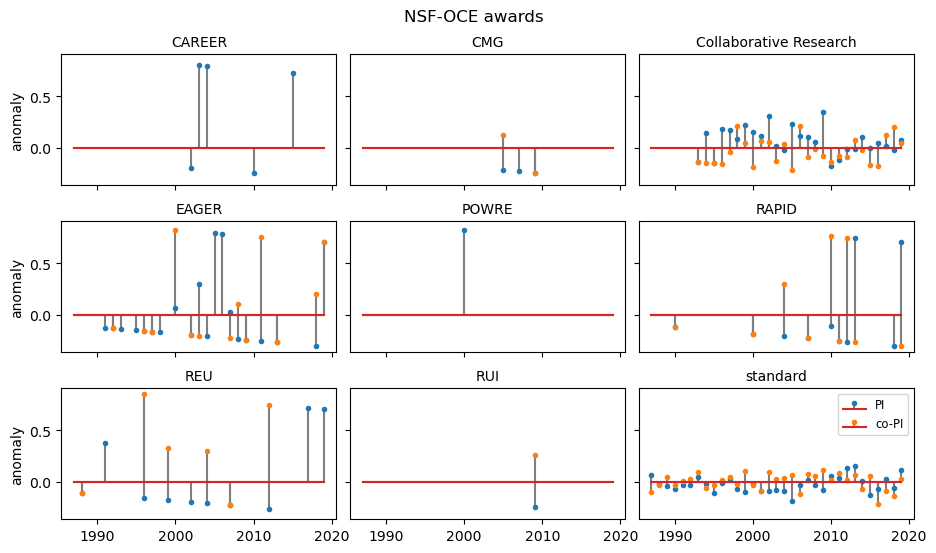

In [40]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(11, 6))
fig.subplots_adjust(hspace=0.275, wspace=0.05, top=0.9)
params = []
for ax, atype in zip(axs.ravel(), female_frac_whoi_by_atype.index.levels[0]):
    if atype == 'CMG':
        legend = True
    else:
        legend=False

    anom = female_frac_whoi_by_atype.loc[atype] - df_ref
    _ = ax.stem(anom.index.values, anom.PI, markerfmt='C0.', linefmt='C7', label='PI')
    _ = ax.stem(anom.index.values, anom['co-PI'], markerfmt='C1.', linefmt='C7', label='co-PI')
    _ = ax.set_title(atype, fontsize=10)
    params.append([anom.sum()[0], anom.sum()[1]])

for i in range(3):
    _ = axs[i,0].set_ylabel('anomaly')

_ = ax.legend(loc='best')
_ = fig.text(0.5,0.95,'NSF-OCE awards', ha='center', va='bottom', fontsize=12)

df_anom = pd.DataFrame(data=params, index=female_frac_whoi_by_atype.index.levels[0], columns=[['total sum','total sum'],['PI', 'co-PI']])
df_anom.style.format('{:.3f}')